In [1]:
import pandas as pd
from google.colab import files
import io

print("Please select the 'Reviews.csv' file to upload.")
uploaded = files.upload()

Please select the 'Reviews.csv' file to upload.


Saving Reviews.csv to Reviews.csv


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/Reviews.csv')
print("Shape of the dataset:", df.shape)

df.head()


Shape of the dataset: (30846, 16)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1


In [4]:
import shutil
shutil.rmtree('/root/nltk_data/tokenizers/punkt', ignore_errors=True)


In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def clean_text_spacy(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        doc = nlp(text)
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        return ' '.join(tokens)
    else:
        return ""

df['cleaned_review'] = df['review_body'].apply(clean_text_spacy)

df[['review_body', 'cleaned_review']].head()


,review_body,cleaned_review
0,Great love it,great love
1,Lots of ads<br />Slow processing speed<br />Oc...,lots adsbr slow processing speedbr occasionall...
2,Excellent unit. The versatility of this table...,excellent unit versatility tablet competitiv...
3,I bought this on Amazon Prime so I ended up bu...,bought amazon prime ended buying gb camera ...
4,All Amazon products continue to meet my expect...,amazon products continue meet expectations


In [10]:
def label_sentiment(star):
    if star in [1, 2]:
        return 'Negative'
    elif star == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment_label'] = df['star_rating'].apply(label_sentiment)

# Show sample
df[['star_rating', 'sentiment_label', 'cleaned_review']].head()


,star_rating,sentiment_label,cleaned_review
0,5,Positive,great love
1,3,Neutral,lots adsbr slow processing speedbr occasionall...
2,5,Positive,excellent unit versatility tablet competitiv...
3,4,Positive,bought amazon prime ended buying gb camera ...
4,5,Positive,amazon products continue meet expectations


/tmp/ipython-input-2633082258.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='Set2')


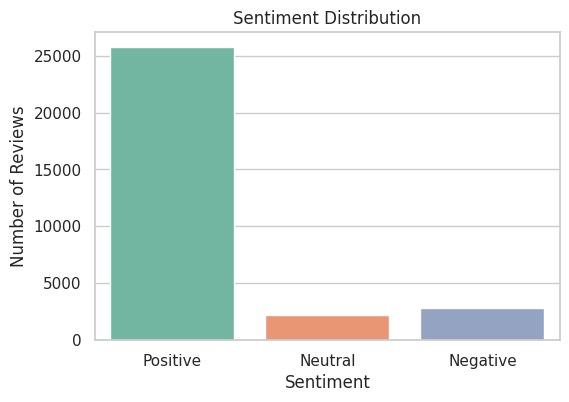

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Countplot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Vectorize text
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_review'])

# 2. Target variable
y = df['sentiment_label']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 5. Predictions
y_pred = model.predict(X_test)

# 6. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8706645056726094

Classification Report:
               precision    recall  f1-score   support

    Negative       0.64      0.51      0.56       572
     Neutral       0.33      0.10      0.15       446
    Positive       0.90      0.98      0.94      5152

    accuracy                           0.87      6170
   macro avg       0.62      0.53      0.55      6170
weighted avg       0.84      0.87      0.85      6170



In [13]:
sample_review = ["I love this product! It's amazing and works perfectly."]

sample_cleaned = clean_text_spacy(sample_review[0])
sample_vector = tfidf.transform([sample_cleaned])

predicted_sentiment = model.predict(sample_vector)[0]
print("Predicted Sentiment:", predicted_sentiment)


Predicted Sentiment: Positive


In [15]:
import numpy as np

# Combine TF-IDF matrix and labels
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['sentiment'] = y.values

# Function to get top N words for a sentiment
def get_top_n_words(class_name, n=10):
    class_group = tfidf_df[tfidf_df['sentiment'] == class_name].drop('sentiment', axis=1)
    mean_tfidf = class_group.mean().sort_values(ascending=False)
    return mean_tfidf.head(n)

# Top words for each class
print("🔴 Negative Sentiment Top Words")
print(get_top_n_words("Negative"))

print("\n🟡 Neutral Sentiment Top Words")
print(get_top_n_words("Neutral"))

print("\n🟢 Positive Sentiment Top Words")
print(get_top_n_words("Positive"))


🔴 Negative Sentiment Top Words
nt              0.062637
kindle          0.041893
amazon          0.036812
fire            0.027878
apps            0.025025
device          0.022944
use             0.022904
like            0.021737
disappointed    0.021544
tablet          0.021498
dtype: float64

🟡 Neutral Sentiment Top Words
nt         0.058434
like       0.036980
kindle     0.034766
good       0.029665
fire       0.029114
battery    0.028474
apps       0.027182
use        0.026942
tablet     0.023552
amazon     0.021823
dtype: float64

🟢 Positive Sentiment Top Words
love      0.132014
great     0.063180
kindle    0.044853
fire      0.039848
use       0.029220
tablet    0.028549
easy      0.025990
like      0.024046
hd        0.023837
good      0.023646
dtype: float64


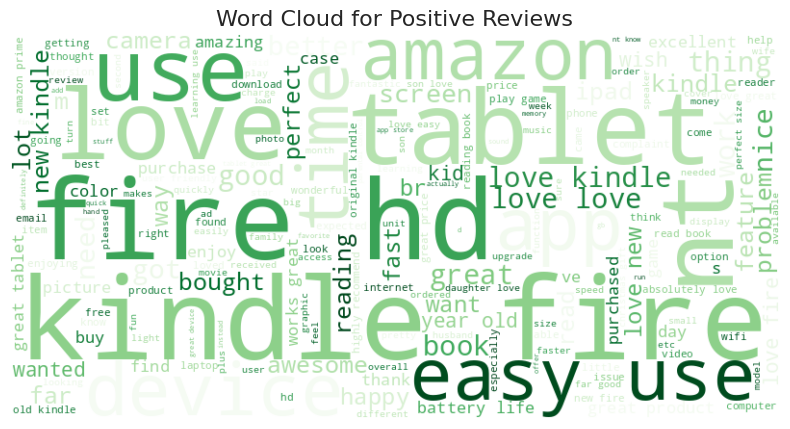

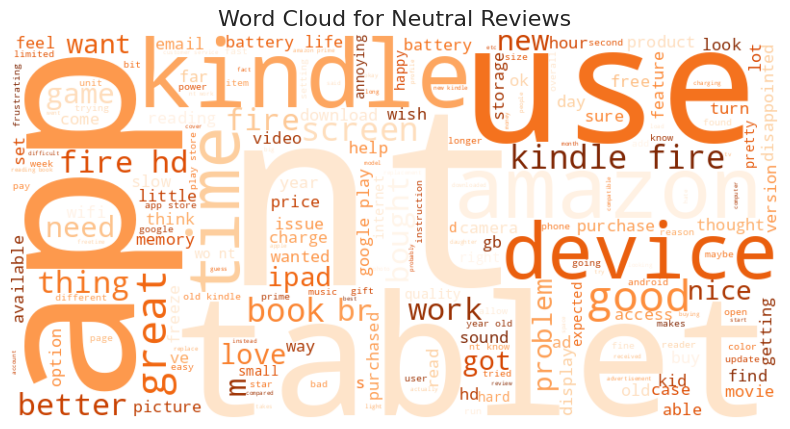

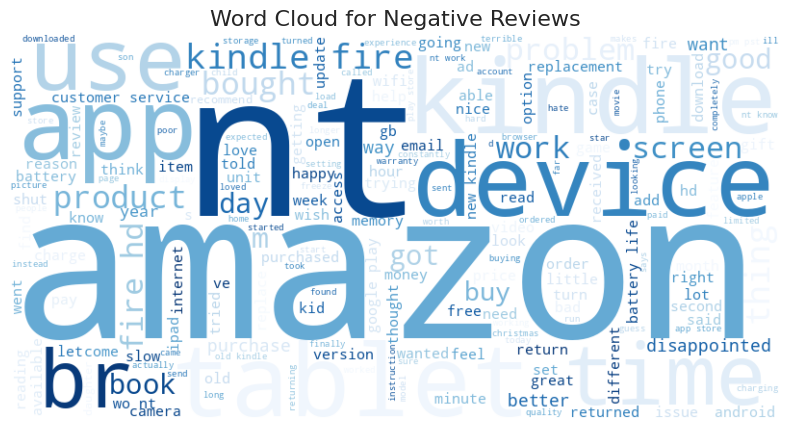

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create WordCloud for a given sentiment
def plot_wordcloud(sentiment, color):
    text = " ".join(df[df['sentiment_label'] == sentiment]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment} Reviews", fontsize=16)
    plt.show()

# Word clouds per sentiment
plot_wordcloud('Positive', 'Greens')
plot_wordcloud('Neutral', 'Oranges')
plot_wordcloud('Negative', 'Blues')


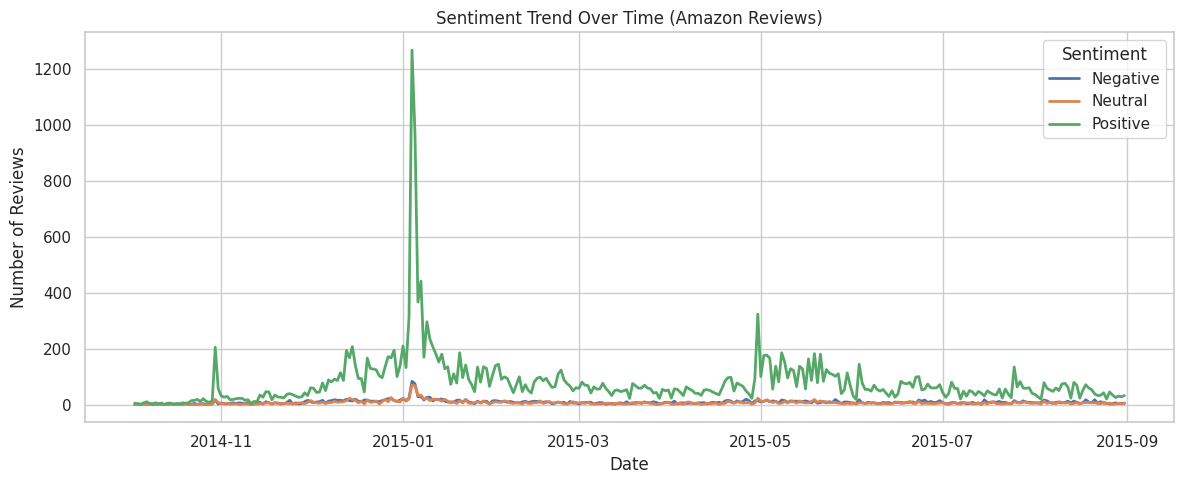

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

# 2. Extract daily trend
df['DATE'] = df['review_date'].dt.date

# 3. Group by date and sentiment
trend = (
    df
    .groupby(['DATE', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
)

# 4. Plot
trend.plot(figsize=(12, 5), linewidth=2)
plt.title("Sentiment Trend Over Time (Amazon Reviews)")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment", loc='upper right')
plt.tight_layout()
plt.show()


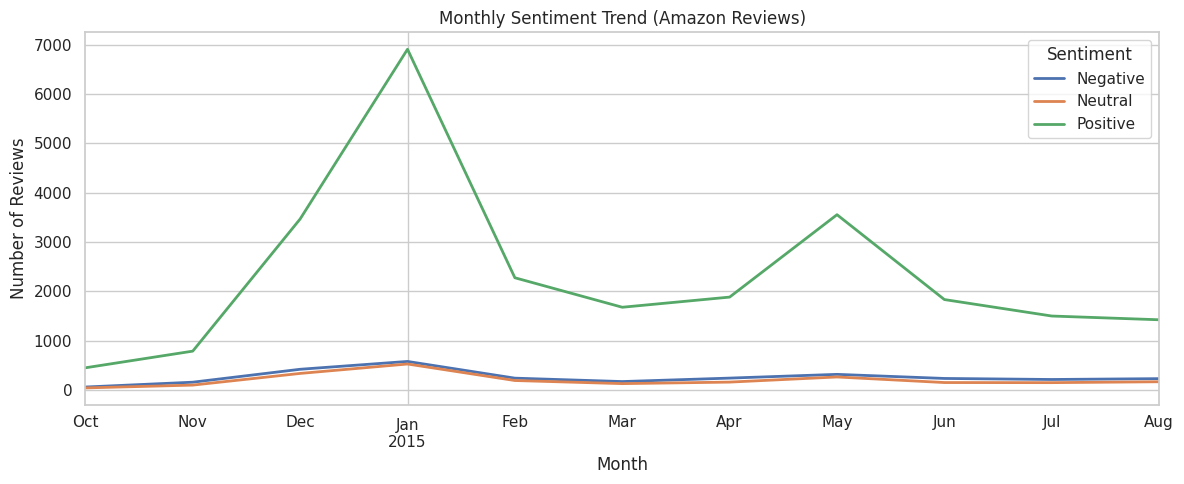

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df['review_date'] = pd.to_datetime(df['review_date'])
df['Month'] = df['review_date'].dt.to_period('M')
monthly_trend = (
    df
    .groupby(['Month', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
)

# 3. Plot
monthly_trend.plot(figsize=(12, 5), linewidth=2)
plt.title("Monthly Sentiment Trend (Amazon Reviews)")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


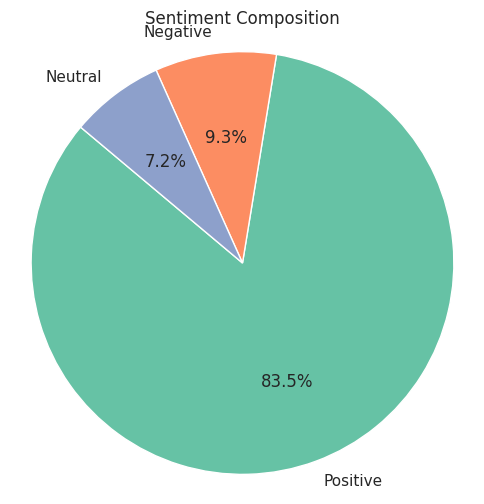

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count sentiment labels
sentiment_counts = df['sentiment_label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set2')
)
plt.title("Sentiment Composition")
plt.axis('equal')  # Ensures the pie is a perfect circle
plt.show()


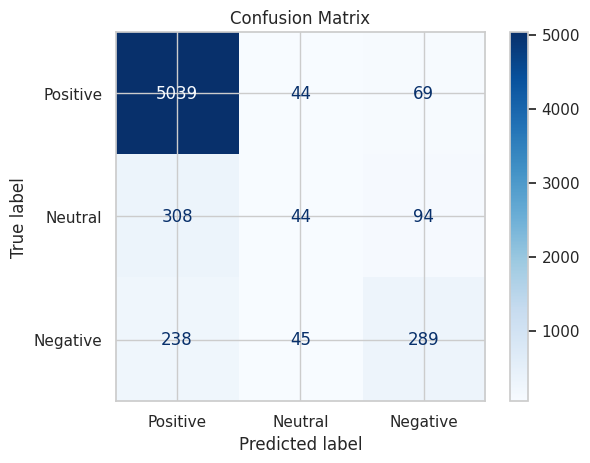

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Neutral', 'Negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


/tmp/ipython-input-594838336.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Set2')


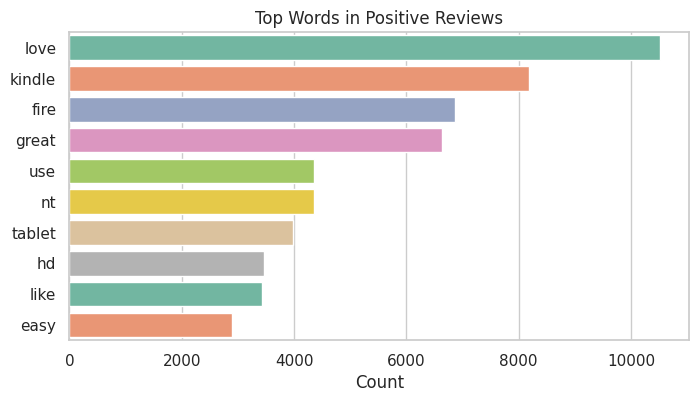

/tmp/ipython-input-594838336.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Set2')


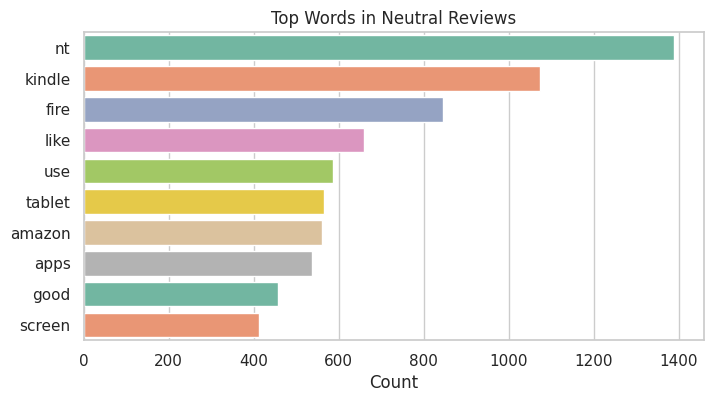

/tmp/ipython-input-594838336.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Set2')


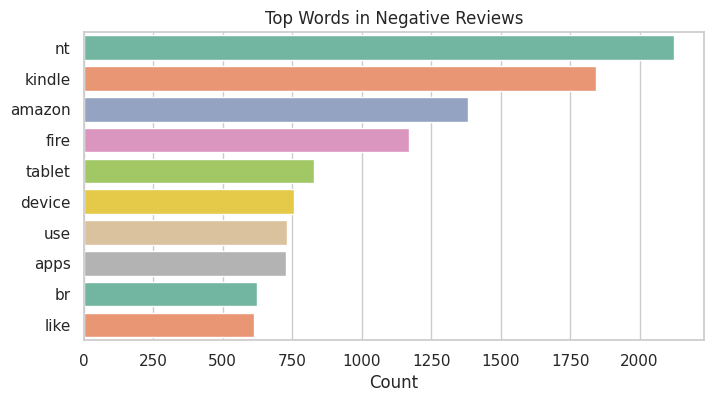

In [23]:
from collections import Counter
import seaborn as sns

def top_words(sentiment, n=10):
    words = " ".join(df[df['sentiment_label'] == sentiment]['cleaned_review']).split()
    return Counter(words).most_common(n)

for sentiment in ['Positive', 'Neutral', 'Negative']:
    common_words = top_words(sentiment)
    words, counts = zip(*common_words)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts), y=list(words), palette='Set2')
    plt.title(f"Top Words in {sentiment} Reviews")
    plt.xlabel("Count")
    plt.show()


In [25]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))


Naive Bayes Accuracy: 0.8607779578606158


In [29]:
df.to_csv("cleaned_reviews.csv", index=False)



In [30]:
from google.colab import files
files.download("cleaned_reviews.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>